In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
import tensorflow as tf
import tensorflow.math as tfmath
import tensorflow.keras as keras
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as sk


2024-06-04 17:04:37.528919: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-04 17:04:37.752530: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
with h5py.File('/eos/home-m/mmcohen/ntuples/AOD_EB_ntuples_04-04-2024.h5', 'r') as hf:
    HLT_jets = hf['HLT_jets'][:]
    L1_jFexSR_jets = hf['L1_jFexSR_jets'][:]
    L1_jFexLR_jets = hf['L1_jFexLR_jets'][:]
    HLT_electrons = hf['HLT_electrons'][:]
    LRT_electrons = hf['LRT_electrons'][:]
    L1_egammas = hf['L1_egammas'][:]
    HLT_muons = hf['HLT_muons'][:]
    LRT_muons = hf['LRT_muons'][:]
    L1_muons = hf['L1_muons'][:]
    L1_eFex_taus = hf['L1_eFex_taus'][:]
    L1_jFex_taus = hf['L1_jFex_taus'][:]
    HLT_photons = hf['HLT_photons'][:]
    HLT_MET = hf['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
    L1_MET = hf['L1_MET'][:].reshape(-1, 1, 4)
    #print(L1_MET.shape)
    #print(L1_MET[0,:,:])
    L1_MET_fixed=np.zeros((997315, 1, 3))
    for i,event in enumerate(L1_MET):
        L1_MET_fixed[i,0,0:2]=event[0,0:2]
        L1_MET_fixed[i,0,2]=event[0,3]
    #print(L1_MET_fixed.shape)
    #print(L1_MET_fixed[0,:,:])
    L1_MET=L1_MET_fixed
    pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
    pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]
    EB_weights = hf["EB_weights"][:]

Topo_2A=[L1_muons,L1_eFex_taus,L1_jFex_taus,L1_jFexLR_jets,L1_jFexSR_jets,L1_MET,L1_egammas]
Topo_2A_labels=['L1_muons','L1_eFex_taus','L1_jFex_taus','L1_jFexLR_jets','L1_jFexSR_jets','L1_MET','L1_egammas']
Topo_2B=[L1_egammas,L1_jFexLR_jets,L1_jFexSR_jets,L1_MET,L1_jFex_taus]
Topo_2B_labels=['L1_egammas','L1_jFexLR_jets','L1_jFexSR_jets','L1_MET','L1_jFex_taus']
Topo_3A=[L1_egammas,L1_eFex_taus,L1_jFex_taus,L1_jFexLR_jets,L1_jFexSR_jets,L1_MET]
Topo_3A_labels=['L1_egammas','L1_eFex_taus','L1_jFex_taus','L1_jFexLR_jets','L1_jFexSR_jets','L1_MET']
#Topo_3B=[L1_muons,L1_egamma,L1_eFex_taus]


Topo_2A_concat=Topo_2A[0]
for i in Topo_2A[1:]:
    print(i.shape)
    Topo_2A_concat=np.append(Topo_2A_concat,i,axis=1)
Topo_2A_flat=np.reshape(Topo_2A_concat,(-1,111))

Topo_2B_concat=Topo_2B[0]
for i in Topo_2B[1:]:
    Topo_2B_concat=np.append(Topo_2B_concat,i,axis=1)
Topo_2B_flat=np.reshape(Topo_2B_concat,(-1,75))

Topo_3A_concat=Topo_3A[0]
for i in Topo_3A[1:]:
    Topo_3A_concat=np.append(Topo_3A_concat,i,axis=1)
Topo_3A_flat=np.reshape(Topo_3A_concat,(-1,93))

L1_pass_test=pass_L1_unprescaled[625000:800000]
HLT_pass_test=pass_HLT_unprescaled[625000:800000]
Topo_2A_test=Topo_2A_flat[450000:800000,:]
Topo_2B_test=Topo_2B_flat[450000:800000,:]
Topo_3A_test=Topo_3A_flat[450000:800000,:]
Topo_test_weights=EB_weights[450000:800000]
 
nans=np.isnan(Topo_2A_test)
a=np.where(nans==True)[0]
for i in a:
    Topo_2A_test[i,92]=0


nans=np.isnan(Topo_2B_test)
b=np.where(nans==True)[0]
for i in b:
    Topo_2B_test[i,56]=0

nans=np.isnan(Topo_3A_test)
c=np.where(nans==True)[0]
for i in c:
    Topo_3A_test[i,92]=0
    
    
Topo_2A_test_br=Topo_2A_test[0:175000]
Topo_2A_test_signal=Topo_2A_test[175000:]

Topo_2B_test_br=Topo_2B_test[0:175000]
Topo_2B_test_signal=Topo_2B_test[175000:]

Topo_3A_test_br=Topo_3A_test[0:175000]
Topo_3A_test_signal=Topo_3A_test[175000:]

Topo_br_weights=Topo_test_weights[0:175000]
Topo_signal_weights=Topo_test_weights[175000:]

(997315, 6, 3)
(997315, 6, 3)
(997315, 6, 3)
(997315, 6, 3)
(997315, 1, 3)
(997315, 6, 3)


In [3]:
with h5py.File('/eos/home-m/mmcohen/ntuples/L1_MC/HHbbttHadHad_04-24-2024.h5', 'r') as hf2:
    HLT_jets2 = hf2['HLT_jets'][:]
    L1_jFexSR_jets2 = hf2['L1_jFexSR_jets'][:,0:6,:]
    L1_jFexLR_jets2 = hf2['L1_jFexLR_jets'][:,0:6,:]
    HLT_electrons2 = hf2['HLT_electrons'][:]
    LRT_electrons2 = hf2['LRT_electrons'][:]
    L1_egammas2 = hf2['L1_egammas'][:]
    HLT_muons2 = hf2['HLT_muons'][:]
    LRT_muons2 = hf2['LRT_muons'][:]
    L1_muons2 = hf2['L1_muons'][:]
    L1_eFex_taus2 = hf2['L1_eFex_taus'][:]
    L1_jFex_taus2 = hf2['L1_jFex_taus'][:]
    HLT_photons2 = hf2['HLT_photons'][:]
    HLT_MET2 = hf2['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
    L1_MET2 = hf2['L1_MET'][:].reshape(-1, 1, 4)
    pass_L1_unprescaled2 = hf2["pass_L1_unprescaled"][:]
    pass_HLT_unprescaled2= hf2["pass_HLT_unprescaled"][:]
    #print(L1_MET.shape)
    #print(L1_MET[0,:,:])
    L1_MET_fixed2=np.zeros((100000, 1, 3))
    for i,event in enumerate(L1_MET2):
        L1_MET_fixed2[i,0,0:2]=event[0,0:2]
        L1_MET_fixed2[i,0,2]=event[0,3]
    #print(L1_MET_fixed.shape)
    #print(L1_MET_fixed[0,:,:])
    L1_MET2=L1_MET_fixed2

    #EB_weights = hf["EB_weights"][:]
Topo_2A_sig_1=[L1_muons2,L1_eFex_taus2,L1_jFex_taus2,L1_jFexLR_jets2,L1_jFexSR_jets2,L1_MET2,L1_egammas2]
Topo_2B_sig_1=[L1_egammas2,L1_jFexLR_jets2,L1_jFexSR_jets2,L1_MET2,L1_jFex_taus2]
Topo_3A_sig_1=[L1_egammas2,L1_eFex_taus2,L1_jFex_taus2,L1_jFexLR_jets2,L1_jFexSR_jets2,L1_MET2]

Topo_2A_concat2=Topo_2A_sig_1[0]
for i in Topo_2A_sig_1[1:]:
    print(i.shape)
    Topo_2A_concat2=np.append(Topo_2A_concat2,i,axis=1)
Topo_2A_HHbbtt=np.reshape(Topo_2A_concat2,(-1,111))
Topo_2A_HHbbtt_unpassed=Topo_2A_HHbbtt[pass_L1_unprescaled2==0]


Topo_2B_concat2=Topo_2B_sig_1[0]
for i in Topo_2B_sig_1[1:]:
    Topo_2B_concat2=np.append(Topo_2B_concat2,i,axis=1)
Topo_2B_HHbbtt=np.reshape(Topo_2B_concat2,(-1,75))
Topo_2B_HHbbtt_unpassed=Topo_2B_HHbbtt[pass_L1_unprescaled2==0]

Topo_3A_concat2=Topo_3A_sig_1[0]
for i in Topo_3A_sig_1[1:]:
    Topo_3A_concat2=np.append(Topo_3A_concat2,i,axis=1)
Topo_3A_HHbbtt=np.reshape(Topo_3A_concat2,(-1,93))
Topo_3A_HHbbtt_unpassed=Topo_3A_HHbbtt[pass_L1_unprescaled2==0]

(100000, 6, 3)
(100000, 6, 3)
(100000, 6, 3)
(100000, 6, 3)
(100000, 1, 3)
(100000, 6, 3)


In [4]:
with h5py.File('/eos/home-m/mmcohen/ntuples/L1_MC/A14N23LO_05-30-2024.h5', 'r') as hf2:
    HLT_jets2 = hf2['HLT_jets'][:]
    L1_jFexSR_jets2 = hf2['L1_jFexSR_jets'][:,0:6,:]
    L1_jFexLR_jets2 = hf2['L1_jFexLR_jets'][:,0:6,:]
    HLT_electrons2 = hf2['HLT_electrons'][:]
    LRT_electrons2 = hf2['LRT_electrons'][:]
    L1_egammas2 = hf2['L1_egammas'][:]
    HLT_muons2 = hf2['HLT_muons'][:]
    LRT_muons2 = hf2['LRT_muons'][:]
    L1_muons2 = hf2['L1_muons'][:]
    L1_eFex_taus2 = hf2['L1_eFex_taus'][:]
    L1_jFex_taus2 = hf2['L1_jFex_taus'][:]
    HLT_photons2 = hf2['HLT_photons'][:]
    HLT_MET2 = hf2['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
    L1_MET2 = hf2['L1_MET'][:].reshape(-1, 1, 4)
    pass_L1_unprescaled2 = hf2["pass_L1_unprescaled"][:]
    pass_HLT_unprescaled2= hf2["pass_HLT_unprescaled"][:]
    #print(L1_MET.shape)
    #print(L1_MET[0,:,:])
    L1_MET_fixed2=np.zeros((10000, 1, 3))
    for i,event in enumerate(L1_MET2):
        L1_MET_fixed2[i,0,0:2]=event[0,0:2]
        L1_MET_fixed2[i,0,2]=event[0,3]
    #print(L1_MET_fixed.shape)
    #print(L1_MET_fixed[0,:,:])
    L1_MET2=L1_MET_fixed2

    #EB_weights = hf["EB_weights"][:]
Topo_2A_sig_1=[L1_muons2,L1_eFex_taus2,L1_jFex_taus2,L1_jFexLR_jets2,L1_jFexSR_jets2,L1_MET2,L1_egammas2]
Topo_2B_sig_1=[L1_egammas2,L1_jFexLR_jets2,L1_jFexSR_jets2,L1_MET2,L1_jFex_taus2]
Topo_3A_sig_1=[L1_egammas2,L1_eFex_taus2,L1_jFex_taus2,L1_jFexLR_jets2,L1_jFexSR_jets2,L1_MET2]

Topo_2A_concat2=Topo_2A_sig_1[0]
for i in Topo_2A_sig_1[1:]:
    print(i.shape)
    Topo_2A_concat2=np.append(Topo_2A_concat2,i,axis=1)
Topo_2A_A14=np.reshape(Topo_2A_concat2,(-1,111))
Topo_2A_A14_unpassed=Topo_2A_A14[pass_L1_unprescaled2==0]


Topo_2B_concat2=Topo_2B_sig_1[0]
for i in Topo_2B_sig_1[1:]:
    Topo_2B_concat2=np.append(Topo_2B_concat2,i,axis=1)
Topo_2B_A14=np.reshape(Topo_2B_concat2,(-1,75))
Topo_2B_A14_unpassed=Topo_2B_A14[pass_L1_unprescaled2==0]

Topo_3A_concat2=Topo_3A_sig_1[0]
for i in Topo_3A_sig_1[1:]:
    Topo_3A_concat2=np.append(Topo_3A_concat2,i,axis=1)
Topo_3A_A14=np.reshape(Topo_3A_concat2,(-1,93))
Topo_3A_A14_unpassed=Topo_3A_A14[pass_L1_unprescaled2==0]

(10000, 6, 3)
(10000, 6, 3)
(10000, 6, 3)
(10000, 6, 3)
(10000, 1, 3)
(10000, 6, 3)


In [5]:
with h5py.File('/eos/home-m/mmcohen/ntuples/L1_MC/HAHMggf_05-30-2024.h5', 'r') as hf2:
    HLT_jets2 = hf2['HLT_jets'][:]
    L1_jFexSR_jets2 = hf2['L1_jFexSR_jets'][:,0:6,:]
    L1_jFexLR_jets2 = hf2['L1_jFexLR_jets'][:,0:6,:]
    HLT_electrons2 = hf2['HLT_electrons'][:]
    LRT_electrons2 = hf2['LRT_electrons'][:]
    L1_egammas2 = hf2['L1_egammas'][:]
    HLT_muons2 = hf2['HLT_muons'][:]
    LRT_muons2 = hf2['LRT_muons'][:]
    L1_muons2 = hf2['L1_muons'][:]
    L1_eFex_taus2 = hf2['L1_eFex_taus'][:]
    L1_jFex_taus2 = hf2['L1_jFex_taus'][:]
    HLT_photons2 = hf2['HLT_photons'][:]
    HLT_MET2 = hf2['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
    L1_MET2 = hf2['L1_MET'][:].reshape(-1, 1, 4)
    pass_L1_unprescaled2 = hf2["pass_L1_unprescaled"][:]
    pass_HLT_unprescaled2= hf2["pass_HLT_unprescaled"][:]
    #print(L1_MET.shape)
    #print(L1_MET[0,:,:])
    L1_MET_fixed2=np.zeros((len(L1_muons2), 1, 3))
    for i,event in enumerate(L1_MET2):
        L1_MET_fixed2[i,0,0:2]=event[0,0:2]
        L1_MET_fixed2[i,0,2]=event[0,3]
    #print(L1_MET_fixed.shape)
    #print(L1_MET_fixed[0,:,:])
    L1_MET2=L1_MET_fixed2

    #EB_weights = hf["EB_weights"][:]
Topo_2A_sig_1=[L1_muons2,L1_eFex_taus2,L1_jFex_taus2,L1_jFexLR_jets2,L1_jFexSR_jets2,L1_MET2,L1_egammas2]
Topo_2B_sig_1=[L1_egammas2,L1_jFexLR_jets2,L1_jFexSR_jets2,L1_MET2,L1_jFex_taus2]
Topo_3A_sig_1=[L1_egammas2,L1_eFex_taus2,L1_jFex_taus2,L1_jFexLR_jets2,L1_jFexSR_jets2,L1_MET2]

Topo_2A_concat2=Topo_2A_sig_1[0]
for i in Topo_2A_sig_1[1:]:
    print(i.shape)
    Topo_2A_concat2=np.append(Topo_2A_concat2,i,axis=1)
Topo_2A_HAHMggf=np.reshape(Topo_2A_concat2,(-1,111))
Topo_2A_A14_HAHMggf=Topo_2A_HAHMggf[pass_L1_unprescaled2==0]


Topo_2B_concat2=Topo_2B_sig_1[0]
for i in Topo_2B_sig_1[1:]:
    Topo_2B_concat2=np.append(Topo_2B_concat2,i,axis=1)
Topo_2B_HAHMggf=np.reshape(Topo_2B_concat2,(-1,75))
Topo_2B_HAHMggf_unpassed=Topo_2B_HAHMggf[pass_L1_unprescaled2==0]

Topo_3A_concat2=Topo_3A_sig_1[0]
for i in Topo_3A_sig_1[1:]:
    Topo_3A_concat2=np.append(Topo_3A_concat2,i,axis=1)
Topo_3A_HAHMggf=np.reshape(Topo_3A_concat2,(-1,93))
Topo_3A_HAHMggf_unpassed=Topo_3A_HAHMggf[pass_L1_unprescaled2==0]

(70000, 6, 3)
(70000, 6, 3)
(70000, 6, 3)
(70000, 6, 3)
(70000, 1, 3)
(70000, 6, 3)


In [6]:
with h5py.File('/eos/home-m/mmcohen/ntuples/L1_MC/qqa_05-30-2024.h5', 'r') as hf2:
    HLT_jets2 = hf2['HLT_jets'][:]
    L1_jFexSR_jets2 = hf2['L1_jFexSR_jets'][:,0:6,:]
    L1_jFexLR_jets2 = hf2['L1_jFexLR_jets'][:,0:6,:]
    HLT_electrons2 = hf2['HLT_electrons'][:]
    LRT_electrons2 = hf2['LRT_electrons'][:]
    L1_egammas2 = hf2['L1_egammas'][:]
    HLT_muons2 = hf2['HLT_muons'][:]
    LRT_muons2 = hf2['LRT_muons'][:]
    L1_muons2 = hf2['L1_muons'][:]
    L1_eFex_taus2 = hf2['L1_eFex_taus'][:]
    L1_jFex_taus2 = hf2['L1_jFex_taus'][:]
    HLT_photons2 = hf2['HLT_photons'][:]
    HLT_MET2 = hf2['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
    L1_MET2 = hf2['L1_MET'][:].reshape(-1, 1, 4)
    pass_L1_unprescaled2 = hf2["pass_L1_unprescaled"][:]
    pass_HLT_unprescaled2= hf2["pass_HLT_unprescaled"][:]
    #print(L1_MET.shape)
    #print(L1_MET[0,:,:])
    L1_MET_fixed2=np.zeros((len(L1_muons2), 1, 3))
    for i,event in enumerate(L1_MET2):
        L1_MET_fixed2[i,0,0:2]=event[0,0:2]
        L1_MET_fixed2[i,0,2]=event[0,3]
    #print(L1_MET_fixed.shape)
    #print(L1_MET_fixed[0,:,:])
    L1_MET2=L1_MET_fixed2

    #EB_weights = hf["EB_weights"][:]
Topo_2A_sig_1=[L1_muons2,L1_eFex_taus2,L1_jFex_taus2,L1_jFexLR_jets2,L1_jFexSR_jets2,L1_MET2,L1_egammas2]
Topo_2B_sig_1=[L1_egammas2,L1_jFexLR_jets2,L1_jFexSR_jets2,L1_MET2,L1_jFex_taus2]
Topo_3A_sig_1=[L1_egammas2,L1_eFex_taus2,L1_jFex_taus2,L1_jFexLR_jets2,L1_jFexSR_jets2,L1_MET2]

Topo_2A_concat2=Topo_2A_sig_1[0]
for i in Topo_2A_sig_1[1:]:
    print(i.shape)
    Topo_2A_concat2=np.append(Topo_2A_concat2,i,axis=1)
Topo_2A_qqa=np.reshape(Topo_2A_concat2,(-1,111))
Topo_2A_A14_qqa=Topo_2A_qqa[pass_L1_unprescaled2==0]


Topo_2B_concat2=Topo_2B_sig_1[0]
for i in Topo_2B_sig_1[1:]:
    Topo_2B_concat2=np.append(Topo_2B_concat2,i,axis=1)
Topo_2B_qqa=np.reshape(Topo_2B_concat2,(-1,75))
Topo_2B_qqa_unpassed=Topo_2B_qqa[pass_L1_unprescaled2==0]

Topo_3A_concat2=Topo_3A_sig_1[0]
for i in Topo_3A_sig_1[1:]:
    Topo_3A_concat2=np.append(Topo_3A_concat2,i,axis=1)
Topo_3A_qqa=np.reshape(Topo_3A_concat2,(-1,93))
Topo_3A_qqa_unpassed=Topo_3A_qqa[pass_L1_unprescaled2==0]

(50000, 6, 3)
(50000, 6, 3)
(50000, 6, 3)
(50000, 6, 3)
(50000, 1, 3)
(50000, 6, 3)


In [7]:
with h5py.File('/eos/home-m/mmcohen/ntuples/L1_MC/Zprime2EJs_05-30-2024.h5', 'r') as hf2:
    HLT_jets2 = hf2['HLT_jets'][:]
    L1_jFexSR_jets2 = hf2['L1_jFexSR_jets'][:,0:6,:]
    L1_jFexLR_jets2 = hf2['L1_jFexLR_jets'][:,0:6,:]
    HLT_electrons2 = hf2['HLT_electrons'][:]
    LRT_electrons2 = hf2['LRT_electrons'][:]
    L1_egammas2 = hf2['L1_egammas'][:]
    HLT_muons2 = hf2['HLT_muons'][:]
    LRT_muons2 = hf2['LRT_muons'][:]
    L1_muons2 = hf2['L1_muons'][:]
    L1_eFex_taus2 = hf2['L1_eFex_taus'][:]
    L1_jFex_taus2 = hf2['L1_jFex_taus'][:]
    HLT_photons2 = hf2['HLT_photons'][:]
    HLT_MET2 = hf2['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
    L1_MET2 = hf2['L1_MET'][:].reshape(-1, 1, 4)
    pass_L1_unprescaled2 = hf2["pass_L1_unprescaled"][:]
    pass_HLT_unprescaled2= hf2["pass_HLT_unprescaled"][:]
    #print(L1_MET.shape)
    #print(L1_MET[0,:,:])
    L1_MET_fixed2=np.zeros((len(L1_muons2), 1, 3))
    for i,event in enumerate(L1_MET2):
        L1_MET_fixed2[i,0,0:2]=event[0,0:2]
        L1_MET_fixed2[i,0,2]=event[0,3]
    #print(L1_MET_fixed.shape)
    #print(L1_MET_fixed[0,:,:])
    L1_MET2=L1_MET_fixed2

    #EB_weights = hf["EB_weights"][:]
Topo_2A_sig_1=[L1_muons2,L1_eFex_taus2,L1_jFex_taus2,L1_jFexLR_jets2,L1_jFexSR_jets2,L1_MET2,L1_egammas2]
Topo_2B_sig_1=[L1_egammas2,L1_jFexLR_jets2,L1_jFexSR_jets2,L1_MET2,L1_jFex_taus2]
Topo_3A_sig_1=[L1_egammas2,L1_eFex_taus2,L1_jFex_taus2,L1_jFexLR_jets2,L1_jFexSR_jets2,L1_MET2]

Topo_2A_concat2=Topo_2A_sig_1[0]
for i in Topo_2A_sig_1[1:]:
    print(i.shape)
    Topo_2A_concat2=np.append(Topo_2A_concat2,i,axis=1)
Topo_2A_Zprime=np.reshape(Topo_2A_concat2,(-1,111))
Topo_2A_Zprime_unpassed=Topo_2A_Zprime[pass_L1_unprescaled2==0]


Topo_2B_concat2=Topo_2B_sig_1[0]
for i in Topo_2B_sig_1[1:]:
    Topo_2B_concat2=np.append(Topo_2B_concat2,i,axis=1)
Topo_2B_Zprime=np.reshape(Topo_2B_concat2,(-1,75))
Topo_2B_Zprime_unpassed=Topo_2B_Zprime[pass_L1_unprescaled2==0]

Topo_3A_concat2=Topo_3A_sig_1[0]
for i in Topo_3A_sig_1[1:]:
    Topo_3A_concat2=np.append(Topo_3A_concat2,i,axis=1)
Topo_3A_Zprime=np.reshape(Topo_3A_concat2,(-1,93))
Topo_3A_Zprime_unpassed=Topo_3A_Zprime[pass_L1_unprescaled2==0]

(100000, 6, 3)
(100000, 6, 3)
(100000, 6, 3)
(100000, 6, 3)
(100000, 1, 3)
(100000, 6, 3)


In [8]:
with h5py.File('/eos/home-m/mmcohen/ntuples/L1_MC/ZZ4lep_05-30-2024.h5', 'r') as hf2:
    HLT_jets2 = hf2['HLT_jets'][:]
    L1_jFexSR_jets2 = hf2['L1_jFexSR_jets'][:,0:6,:]
    L1_jFexLR_jets2 = hf2['L1_jFexLR_jets'][:,0:6,:]
    HLT_electrons2 = hf2['HLT_electrons'][:]
    LRT_electrons2 = hf2['LRT_electrons'][:]
    L1_egammas2 = hf2['L1_egammas'][:]
    HLT_muons2 = hf2['HLT_muons'][:]
    LRT_muons2 = hf2['LRT_muons'][:]
    L1_muons2 = hf2['L1_muons'][:]
    L1_eFex_taus2 = hf2['L1_eFex_taus'][:]
    L1_jFex_taus2 = hf2['L1_jFex_taus'][:]
    HLT_photons2 = hf2['HLT_photons'][:]
    HLT_MET2 = hf2['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
    L1_MET2 = hf2['L1_MET'][:].reshape(-1, 1, 4)
    pass_L1_unprescaled2 = hf2["pass_L1_unprescaled"][:]
    pass_HLT_unprescaled2= hf2["pass_HLT_unprescaled"][:]
    #print(L1_MET.shape)
    #print(L1_MET[0,:,:])
    L1_MET_fixed2=np.zeros((len(L1_muons2), 1, 3))
    for i,event in enumerate(L1_MET2):
        L1_MET_fixed2[i,0,0:2]=event[0,0:2]
        L1_MET_fixed2[i,0,2]=event[0,3]
    #print(L1_MET_fixed.shape)
    #print(L1_MET_fixed[0,:,:])
    L1_MET2=L1_MET_fixed2

    #EB_weights = hf["EB_weights"][:]
Topo_2A_sig_1=[L1_muons2,L1_eFex_taus2,L1_jFex_taus2,L1_jFexLR_jets2,L1_jFexSR_jets2,L1_MET2,L1_egammas2]
Topo_2B_sig_1=[L1_egammas2,L1_jFexLR_jets2,L1_jFexSR_jets2,L1_MET2,L1_jFex_taus2]
Topo_3A_sig_1=[L1_egammas2,L1_eFex_taus2,L1_jFex_taus2,L1_jFexLR_jets2,L1_jFexSR_jets2,L1_MET2]

Topo_2A_concat2=Topo_2A_sig_1[0]
for i in Topo_2A_sig_1[1:]:
    print(i.shape)
    Topo_2A_concat2=np.append(Topo_2A_concat2,i,axis=1)
Topo_2A_ZZ4lep=np.reshape(Topo_2A_concat2,(-1,111))
Topo_2A_ZZ4lep_unpassed=Topo_2A_ZZ4lep[pass_L1_unprescaled2==0]


Topo_2B_concat2=Topo_2B_sig_1[0]
for i in Topo_2B_sig_1[1:]:
    Topo_2B_concat2=np.append(Topo_2B_concat2,i,axis=1)
Topo_2B_ZZ4lep=np.reshape(Topo_2B_concat2,(-1,75))
Topo_2B_ZZ4lep_unpassed=Topo_2B_ZZ4lep[pass_L1_unprescaled2==0]

Topo_3A_concat2=Topo_3A_sig_1[0]
for i in Topo_3A_sig_1[1:]:
    Topo_3A_concat2=np.append(Topo_3A_concat2,i,axis=1)
Topo_3A_ZZ4lep=np.reshape(Topo_3A_concat2,(-1,93))
Topo_3A_ZZ4lep_unpassed=Topo_3A_ZZ4lep[pass_L1_unprescaled2==0]

(100000, 6, 3)
(100000, 6, 3)
(100000, 6, 3)
(100000, 6, 3)
(100000, 1, 3)
(100000, 6, 3)


In [9]:
with h5py.File('/eos/home-m/mmcohen/ntuples/L1_MC/jjJZ2_04-24-2024.h5', 'r') as hf3:
    HLT_jets3 = hf3['HLT_jets'][:]
    L1_jFexSR_jets3 = hf3['L1_jFexSR_jets'][:,0:6,:]
    L1_jFexLR_jets3 = hf3['L1_jFexLR_jets'][:,0:6,:]
    HLT_electrons3 = hf3['HLT_electrons'][:]
    LRT_electrons3 = hf3['LRT_electrons'][:]
    L1_egammas3 = hf3['L1_egammas'][:]
    HLT_muons3 = hf3['HLT_muons'][:]
    LRT_muons3 = hf3['LRT_muons'][:]
    L1_muons3 = hf3['L1_muons'][:]
    L1_eFex_taus3 = hf3['L1_eFex_taus'][:]
    L1_jFex_taus3 = hf3['L1_jFex_taus'][:]
    HLT_photons3 = hf3['HLT_photons'][:]
    HLT_MET3 = hf3['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
    L1_MET3 = hf3['L1_MET'][:].reshape(-1, 1, 4)
    #print(L1_MET.shape)
    #print(L1_MET[0,:,:])
    L1_MET_fixed3=np.zeros((100000, 1, 3))
    for i,event in enumerate(L1_MET3):
        L1_MET_fixed3[i,0,0:2]=event[0,0:2]
        L1_MET_fixed3[i,0,2]=event[0,3]
    #print(L1_MET_fixed.shape)
    #print(L1_MET_fixed[0,:,:])
    L1_MET3=L1_MET_fixed3
    #EB_weights = hf["EB_weights"][:]
Topo_2A_jz2=[L1_muons3,L1_eFex_taus3,L1_jFex_taus3,L1_jFexLR_jets3,L1_jFexSR_jets3,L1_MET3,L1_egammas3]
Topo_2B_jz2=[L1_egammas3,L1_jFexLR_jets3,L1_jFexSR_jets3,L1_MET3,L1_jFex_taus3]
Topo_3A_jz2=[L1_egammas3,L1_eFex_taus3,L1_jFex_taus3,L1_jFexLR_jets3,L1_jFexSR_jets3,L1_MET3]

Topo_2A_concat3=Topo_2A_jz2[0]
for i in Topo_2A_jz2[1:]:
    print(i.shape)
    Topo_2A_concat3=np.append(Topo_2A_concat3,i,axis=1)
Topo_2A_jz2=np.reshape(Topo_2A_concat3,(-1,111))

Topo_2B_concat3=Topo_2B_jz2[0]
for i in Topo_2B_jz2[1:]:
    Topo_2B_concat3=np.append(Topo_2B_concat3,i,axis=1)
Topo_2B_jz2=np.reshape(Topo_2B_concat3,(-1,75))

Topo_3A_concat3=Topo_3A_jz2[0]
for i in Topo_3A_jz2[1:]:
    Topo_3A_concat3=np.append(Topo_3A_concat3,i,axis=1)
Topo_3A_jz2=np.reshape(Topo_3A_concat3,(-1,93))

(100000, 6, 3)
(100000, 6, 3)
(100000, 6, 3)
(100000, 6, 3)
(100000, 1, 3)
(100000, 6, 3)


In [10]:
with h5py.File('/eos/home-m/mmcohen/ntuples/L1_MC/jjJZ4_04-24-2024.h5', 'r') as hf4:
    HLT_jets4 = hf4['HLT_jets'][:]
    L1_jFexSR_jets4 = hf4['L1_jFexSR_jets'][:,0:6,:]
    L1_jFexLR_jets4 = hf4['L1_jFexLR_jets'][:,0:6,:]
    HLT_electrons4 = hf4['HLT_electrons'][:]
    LRT_electrons4 = hf4['LRT_electrons'][:]
    L1_egammas4 = hf4['L1_egammas'][:]
    HLT_muons4 = hf4['HLT_muons'][:]
    LRT_muons4 = hf4['LRT_muons'][:]
    L1_muons4 = hf4['L1_muons'][:]
    L1_eFex_taus4 = hf4['L1_eFex_taus'][:]
    L1_jFex_taus4 = hf4['L1_jFex_taus'][:]
    HLT_photons4 = hf4['HLT_photons'][:]
    HLT_MET4 = hf4['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
    L1_MET4 = hf4['L1_MET'][:].reshape(-1, 1, 4)
    #print(L1_MET.shape)
    #print(L1_MET[0,:,:])
    L1_MET_fixed4=np.zeros((100000, 1, 3))
    for i,event in enumerate(L1_MET4):
        L1_MET_fixed4[i,0,0:2]=event[0,0:2]
        L1_MET_fixed4[i,0,2]=event[0,3]
    #print(L1_MET_fixed.shape)
    #print(L1_MET_fixed[0,:,:])
    L1_MET4=L1_MET_fixed4
    #EB_weights = hf["EB_weights"][:]
Topo_2A_jz4=[L1_muons4,L1_eFex_taus4,L1_jFex_taus4,L1_jFexLR_jets4,L1_jFexSR_jets4,L1_MET4,L1_egammas4]
Topo_2B_jz4=[L1_egammas4,L1_jFexLR_jets4,L1_jFexSR_jets4,L1_MET4,L1_jFex_taus4]
Topo_3A_jz4=[L1_egammas4,L1_eFex_taus4,L1_jFex_taus4,L1_jFexLR_jets4,L1_jFexSR_jets4,L1_MET4]

Topo_2A_concat4=Topo_2A_jz4[0]
for i in Topo_2A_jz4[1:]:
    print(i.shape)
    Topo_2A_concat4=np.append(Topo_2A_concat4,i,axis=1)
Topo_2A_jz4=np.reshape(Topo_2A_concat4,(-1,111))

Topo_2B_concat4=Topo_2B_jz4[0]
for i in Topo_2B_jz4[1:]:
    Topo_2B_concat4=np.append(Topo_2B_concat4,i,axis=1)
Topo_2B_jz4=np.reshape(Topo_2B_concat4,(-1,75))

Topo_3A_concat4=Topo_3A_jz4[0]
for i in Topo_3A_jz4[1:]:
    Topo_3A_concat4=np.append(Topo_3A_concat4,i,axis=1)
Topo_3A_jz4=np.reshape(Topo_3A_concat4,(-1,93))

(100000, 6, 3)
(100000, 6, 3)
(100000, 6, 3)
(100000, 6, 3)
(100000, 1, 3)
(100000, 6, 3)


In [11]:
#Here I section off some additional signals
Topo_2A_HLT_passed=Topo_2A_test_signal[HLT_pass_test==1]
Topo_2A_L1_passed=Topo_2A_test_signal[L1_pass_test==1]
Topo_2A_just_L1_passed=Topo_2A_L1_passed[HLT_pass_test[L1_pass_test==1]==0]

Topo_2B_HLT_passed=Topo_2B_test_signal[HLT_pass_test==1]
Topo_2B_L1_passed=Topo_2B_test_signal[L1_pass_test==1]
Topo_2B_just_L1_passed=Topo_2B_L1_passed[HLT_pass_test[L1_pass_test==1]==0]

Topo_3A_HLT_passed=Topo_3A_test_signal[HLT_pass_test==1]
Topo_3A_L1_passed=Topo_3A_test_signal[L1_pass_test==1]
Topo_3A_just_L1_passed=Topo_3A_L1_passed[HLT_pass_test[L1_pass_test==1]==0]

In [12]:
print(len(EB_weights))
print(len(pass_L1_unprescaled))
print(len(pass_HLT_unprescaled))
passed_none=0
passed_L1=0
passed_hlt=0
passed_just_L1=0
passed_just_hlt=0
for i in range(0,len(EB_weights)):
    if pass_L1_unprescaled[i]==0 and pass_HLT_unprescaled[i]==0:
        passed_none+=1
    if pass_L1_unprescaled[i]==1 and pass_HLT_unprescaled[i]==0:
        passed_just_L1+=1
    if pass_L1_unprescaled[i]==1:
        passed_L1+=1
    if pass_L1_unprescaled[i]==0 and pass_HLT_unprescaled[i]==1:
        passed_just_hlt+=1
    if pass_HLT_unprescaled[i]==1:
        passed_hlt+=1

print('__Triggers__    __Num Passed__')
print('    none          {}'.format(passed_none))
print('     L1           {}'.format(passed_L1))
print('   Just L1        {}'.format(passed_just_L1))
print('     HLT          {}'.format(passed_hlt))
print('   Just HLT       {}'.format(passed_just_hlt))
print('L1- Just L1       {}'.format(passed_L1-passed_just_L1))
print('HLT-Just HLT      {}'.format(passed_hlt-passed_just_hlt))
    

997315
997315
997315
__Triggers__    __Num Passed__
    none          777039
     L1           219467
   Just L1        212426
     HLT          7850
   Just HLT       809
L1- Just L1       7041
HLT-Just HLT      7041


In [13]:

class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


def make_encoder(input_dim,h_dim_1,h_dim_2,latent_dim):
    inputs=keras.Input(shape=(input_dim))
    x=layers.BatchNormalization()(inputs)
    x=layers.Dense(h_dim_1, activation='relu')(x)
    x=layers.Dense(h_dim_2, activation='relu')(x)
    z_mean=layers.Dense(latent_dim)(x)
    z_logvar=layers.Dense(latent_dim)(x)
    z=Sampling()([z_mean,z_logvar])
    encoder=keras.Model(inputs,[z_mean,z_logvar,z],name='encoder')
    return encoder

def make_encoder2(input_dim,h_dim_1,latent_dim):
    inputs=keras.Input(shape=(input_dim))
    x=layers.Dense(h_dim_1, activation='relu')(inputs)
    z_mean=layers.Dense(latent_dim, activation='relu')(x)
    z_logvar=layers.Dense(latent_dim, activation='relu')(x)
    z=Sampling()([z_mean,z_logvar])
    encoder=keras.Model(inputs,[z_mean,z_logvar,z],name='encoder')
    return encoder

def make_decoder2(input_dim,h_dim_1,latent_dim):
    
    inputs=keras.Input(shape=(latent_dim))
    x=layers.Dense(h_dim_1, activation='relu')(inputs)
    z=layers.Dense(input_dim, activation='relu')(x)
    decoder=keras.Model(inputs,z,name='decoder')
    return decoder

def make_decoder(input_dim,h_dim_1,h_dim_2,latent_dim):
    inputs=keras.Input(shape=(latent_dim))
    x=layers.Dense(h_dim_2, activation='relu')(inputs)
    x=layers.Dense(h_dim_1, activation='relu')(x)
    z=layers.Dense(input_dim)(x)
    decoder=keras.Model(inputs,z,name='decoder')
    return decoder

class VAE_Model(keras.Model):
    def __init__(self,encoder,decoder,**kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta=1

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def set_beta(self,beta):
        self.beta=beta
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            #making a masked loss function
            mask = K.cast(K.not_equal(data, 0), K.floatx())
            
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.mse(mask*data, mask*reconstruction)))

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            
            #I changed the KL loss term to just be a sum
            kl_loss = tf.reduce_sum(kl_loss)

            #kl_loss *= 0
            total_loss = (1-self.beta)*reconstruction_loss + self.beta*kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reco_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        
        reconstruction = self.decoder(z)
        mask = K.cast(K.not_equal(data, 0), K.floatx())
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.mse(mask*data, mask*reconstruction)))

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_sum(kl_loss)
        #kl_loss *= 0
        total_loss = (1-self.beta)*reconstruction_loss + self.beta*kl_loss
        return {
            "loss": total_loss,
            "reco_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        z_mean,z_log_var,x = self.encoder(data)
        reconstruction = self.decoder(x)
        return {
            "z_mean": z_mean,
            "z_log_var": z_log_var,
            "reconstruction": reconstruction
        }

        
    

def total_loss(signal,predict,z_mean,z_log_var,beta):
    re_loss=np.mean((signal-predict)**2)
    kl_loss=np.sum(-0.5 * (1 + z_log_var - (z_mean)**2 - np.exp(z_log_var)))
    tot_loss=re_loss+beta*kl_loss
    return tot_loss
def AD_score(s,p,z_m,z_log,beta):
    mask = (s!=0)
    
    _s=s*mask
    _p=p*mask
    
    p=mask*p
    return total_loss(_s,_p,z_m,z_log,beta)

def AD_score_MSE(s,p):
    mask = (s!=0)
    s1=s*mask
    p1=p*mask
    re_loss=np.mean((s1-p1)**2)
    return re_loss

def AD_score_KL(z_mean,z_log_var):
    kl_loss=np.mean(-0.5 * (1 + z_log_var - (z_mean)**2 - np.exp(z_log_var)))
    return kl_loss

def AD_score_Rz(z_mean,z_log_var):
    Rz_loss=np.mean((z_mean**2)/(np.exp(z_log_var)))
    return Rz_loss

def AD_score_CKL(z_mean,z_log_var):
    CKL=np.mean(z_mean**2)
    return CKL
    

class Model_Evaluator():
  def __init__(self,model_path,backround,br_weights,signal,signal_weights,input_dim,title='placeholder',save=False,labels=None):

    self.input_dim=input_dim
    vae_enc=make_encoder(input_dim,32,16,3)
    vae_dec=make_decoder(input_dim,32,16,3)
    #vae_enc=make_encoder2(57,16,3)
    #vae_dec=make_decoder2(57,16,3)
    self.model=VAE_Model(vae_enc,vae_dec)
    self.model.load_weights(model_path)
    self.encoder=self.model.get_layer('encoder')
    self.signal=signal
    self.backround=backround
    self.br_loss=[]
    self.signal_loss=[]
    self.backround_outputs=[]
    self.signal_outputs=[]
    self.title=title
    self.saveplots=save
    self.labels=labels
    self.latent_info=[]
    self.br_weights=br_weights
    self.signal_weights=signal_weights

  def calculate_loss(self,l_type):
    self.signal_loss=[]
    self.br_loss=[]
    br=self.backround
    
    if l_type=='CKL':
        br_latent=np.array(self.encoder.predict(br))
        self.latent_info+=[br_latent[0]]
        l=[]
        for i in range(0,br.shape[0]):
            loss=AD_score_CKL(br_latent[0][i],br_latent[1][i])
            l+=[loss]
        self.br_loss= l

        
        for i, batch in enumerate(self.signal):
            sg_latent=np.array(self.encoder.predict(batch))
            self.latent_info+=[sg_latent[0]]
            l=[]
        
            for i in range(0,batch.shape[0]):
                loss=AD_score_CKL(sg_latent[0][i],sg_latent[1][i])
                l+=[loss]
    
            sg_loss= l
        
            self.signal_loss+=[sg_loss]            
            
            

    
    
    if l_type=='KL':
        br_latent=np.array(self.encoder.predict(br))
        l=[]
        for i in range(0,br.shape[0]):
            loss=AD_score_KL(br_latent[0][i],br_latent[1][i])
            l+=[loss]
        self.br_loss= l

        
        for i, batch in enumerate(self.signal):
            sg_latent=np.array(self.encoder.predict(batch))
        
            l=[]
        
            for i in range(0,batch.shape[0]):
                loss=AD_score_KL(sg_latent[0][i],sg_latent[1][i])
                l+=[loss]
    
            sg_loss= l
        
            self.signal_loss+=[sg_loss]
    
    if l_type=='Rz':
        br_latent=np.array(self.encoder.predict(br))
        l=[]
        for i in range(0,br.shape[0]):
            loss=AD_score_Rz(br_latent[0][i],br_latent[1][i])
            l+=[loss]
        self.br_loss= l

        
        for i, batch in enumerate(self.signal):
            sg_latent=np.array(self.encoder.predict(batch))
        
            l=[]
        
            for i in range(0,batch.shape[0]):
                loss=AD_score_Rz(sg_latent[0][i],sg_latent[1][i])
                l+=[loss]
    
            sg_loss= l
        
            self.signal_loss+=[sg_loss]
    
    
    
    
    if l_type=='MSE':
        br_predict=np.array(self.model.predict(br)['reconstruction'])
        l=[]
        for i in range(0,br.shape[0]):
            loss=AD_score_MSE(br[i],br_predict[i])
            l+=[loss]
        self.br_loss= l
        
        for i, batch in enumerate(self.signal):
            sg_predict=np.array(self.model.predict(batch)['reconstruction'])      
            l=[]
        
            for i in range(0,batch.shape[0]):
                loss=AD_score_MSE(batch[i],sg_predict[i])
                l+=[loss]
    
            sg_loss= l
        
            self.signal_loss+=[sg_loss]

    return [self.br_loss,self.signal_loss]


  def histogram(self,bins):
    plt.hist(self.br_loss,weights=self.br_weights,bins=bins,histtype='step',label='backround num_events:{}'.format(len(self.br_loss)))
    for i,batch in enumerate(self.signal_loss):
      plt.hist(batch,weights=self.signal_weights[i],bins=bins,histtype='step',label=str(self.labels[i])+" num_events:{}".format(len(batch)))
    plt.xlabel('loss')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.title("{}_Hist".format(self.title))
    plt.legend()
    if self.saveplots==True:
      plt.savefig("/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{}_Hist.png".format(self.title), format="png", bbox_inches="tight")
    plt.show()

  def ROC(self):
    plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),'--',label='diagonal')
    for j, batch in enumerate(self.signal_loss):
      sig_w=self.signal_weights[j]
      br_w=self.br_weights
      weights=np.concatenate((br_w,sig_w))
      truth=[]
      for i in range(len(self.br_loss)):
        truth+=[0]
      for i in range(len(batch)):
        truth+=[1]
      ROC_data=np.concatenate((self.br_loss,batch))
      fpr,tpr,x=sk.roc_curve(truth,ROC_data,sample_weight=weights)
    #auc=np.trapz(tpr,fpr)
      auc=sk.roc_auc_score(truth,ROC_data)
      plt.plot(fpr,tpr,label=self.labels[j]+": "+str(round(auc,3)))

    plt.xlabel('fpr')
    plt.semilogx()
    plt.ylabel('tpr')
    plt.semilogy()
    plt.title("{}_ROC".format(self.title))
    #plt.vlines(10**-5,0,1,colors='r',linestyles='dashed')
    plt.legend(loc='lower right')
    if self.saveplots==True:
      plt.savefig("/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{}_ROC.png".format(self.title), format="png", bbox_inches="tight")
    plt.show()
    
  def weighted_S_F(self,rate1):
    sf_list=[]
    for j, batch in enumerate(self.signal_loss):
      sig_w=self.signal_weights[j]
      br_w=self.br_weights
      weights=np.concatenate((br_w,sig_w))
      truth=[]
      for i in range(len(self.br_loss)):
        truth+=[0]
      for i in range(len(batch)):
        truth+=[1]
      ROC_data=np.concatenate((self.br_loss,batch))
      fpr,tpr,x=sk.roc_curve(truth,ROC_data,sample_weight=weights)
    #auc=np.trapz(tpr,fpr)
      saved=0
      saved_index=0
      for k,f in enumerate(fpr):
        if f>saved and f<=rate1:
            saved=f
            saved_index=k
      sf_list+=[tpr[saved_index]]
    return sf_list
    
  def Plot_3D(self):
    fig=plt.figure()
    ax=fig.add_subplot(projection='3d')
    for i, signal in enumerate(self.latent_info):
        sig_tuple=np.array(signal)
        print(sig_tuple.shape)
        x=sig_tuple[0:100,0]
        y=sig_tuple[0:100,1]
        z=sig_tuple[0:100,2]
        ax.scatter(x,y,z,label=self.labels[i],marker='.')
    plt.legend()
    plt.show()

  def Plot_2D(self):
    #xy
    for i, signal in enumerate(self.latent_info[1:]):
        sig_tuple=np.array(signal)
        x=sig_tuple[:,0]
        y=sig_tuple[:,1]
        plt.plot(x,y,'o',label=self.labels[i],alpha=0.5)
    sig_tuple_br=np.array(self.latent_info[0])
    x=sig_tuple_br[:,0]
    y=sig_tuple_br[:,1]
    plt.plot(x,y,'or',label='br',alpha=0.5)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()
    
    
    #xz
    for i, signal in enumerate(self.latent_info[1:]):
        sig_tuple=np.array(signal)
        x=sig_tuple[:,0]
        z=sig_tuple[:,2]
        plt.plot(x,z,'o',label=self.labels[i],alpha=0.5)
    sig_tuple_br=np.array(self.latent_info[0])
    x=sig_tuple_br[:,0]
    z=sig_tuple_br[:,2]
    plt.plot(x,z,'or',label='br',alpha=0.5)
    plt.xlabel('x')
    plt.ylabel('z')
    plt.legend()
    plt.show()
    
    
    
    #yz
    for i, signal in enumerate(self.latent_info[1:]):
        sig_tuple=np.array(signal)
        y=sig_tuple[:,1]
        z=sig_tuple[:,2]
        plt.plot(y,z,'o',label=self.labels[i],alpha=0.5)
    sig_tuple_br=np.array(self.latent_info[0])
    y=sig_tuple_br[:,1]
    z=sig_tuple_br[:,2]
    plt.plot(y,z,'or',label='br',alpha=0.5)
    plt.xlabel('y')
    plt.ylabel('z')
    plt.legend()
    plt.show()

  def SIC(self):
    #plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),'--',label='diagonal')
    for j, batch in enumerate(self.signal_loss):
      truth=[]
      for i in range(len(self.br_loss)):
        truth+=[0]
      for i in range(len(batch)):
        truth+=[1]
      ROC_data=np.concatenate((self.br_loss,batch))
      fpr,tpr,x=sk.roc_curve(truth,ROC_data)
    #auc=np.trapz(tpr,fpr)
      auc=sk.roc_auc_score(truth,ROC_data)
      plt.plot(fpr,tpr/np.sqrt(fpr),label=self.labels[j+1])

    plt.xlabel('fpr')
    plt.semilogx()
    plt.ylabel('trp/sqrt(fpr)')
    plt.title("{}_SIC".format(self.title))
    plt.legend()
    if self.saveplots==True:
      plt.savefig("/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{}_SIC.png".format(self.title), format="png", bbox_inches="tight")
    plt.show()
    
  def Sensitivity(self):
    #plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),'--',label='diagonal')
    for j, batch in enumerate(self.signal_loss):
      truth=[]
      for i in range(len(self.br_loss)):
        truth+=[0]
      for i in range(len(batch)):
        truth+=[1]
      ROC_data=np.concatenate((self.br_loss,batch))
      fpr,tpr,x=sk.roc_curve(truth,ROC_data)
    #auc=np.trapz(tpr,fpr)
      auc=sk.roc_auc_score(truth,ROC_data)
      plt.plot(fpr,tpr/fpr,label=self.labels[j+1])

    plt.xlabel('fpr')
    plt.semilogx()
    plt.ylabel('trp/fpr')
    plt.semilogy()
    plt.title("{}_Sensitivity".format(self.title))
    plt.legend()
    if self.saveplots==True:
      plt.savefig("/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{}_tpr_fpr.png".format(self.title), format="png", bbox_inches="tight")
    plt.show()
    
    
    
  def S_F(self,true_br_rate,desired_br_rate):
    N=len(self.br_loss)
    n=int(np.round(N*(desired_br_rate/true_br_rate)))
    br=self.br_loss
    br.sort()
    AD=br[-(n+1)]
    print(AD)
    sensitivity=[]
    for i,losses in enumerate(self.signal_loss):
        N=len(losses)
        n=0
        for loss in losses:
            if loss>=AD:
                n+=1
        sen=n/N
        sensitivity+=[sen]
    self.signal_sensitivity=sensitivity
    return self.signal_sensitivity
    
  
  def Find_AD_Cutoff(self,br_rate,desired_rate,starting_AD):
    N=self.backround.shape[0]
    AD_max=starting_AD
    AD_List=np.linspace(0,AD_max,num=1000)
    best_AD=0
    for i,AD in enumerate(np.flip(AD_List)):
      n=0
      for loss in self.br_loss:
        if loss>=AD:
          n+=1
      sigrate=br_rate*n/N
      if sigrate<=desired_rate:
        best_AD=AD
      if sigrate>desired_rate:
        break
    self.AD_cutoff=best_AD
    return best_AD
    
  def calculate_sensitivity(self,br_rate):
    AD=self.AD_cutoff
    sensitivity=[]
    for i,losses in enumerate(self.signal_loss):
        N=len(losses)
        n=0
        for loss in losses:
            if loss>=AD:
                n+=1
        sen=n/N
        sensitivity+=[sen]
    self.signal_sensitivity=sensitivity
    print(self.signal_sensitivity)

  def event_anomally_checker(self,rate):
    N=len(self.br_loss)
    n=int(np.round(N*(rate)))
    br=self.br_loss
    br.sort()
    AD=br[-(n+1)]
    sensitivity=[]
    anomalous_events=[]
    for i,losses in enumerate(self.signal_loss):
        anomalous_signs=[]
        for i,loss in enumerate(losses):
            if loss>=AD:
                anomalous_signs+=[i]
        anomalous_events+=[anomalous_signs]
    return anomalous_events
      
  def pt_correlation(self):
      pt_num=self.input_dim//3
      print(pt_num)
      for k,sig in enumerate(self.signal):
          tot_pt_per_event=[]
          for event in sig:
              pt=0
              for i in range(0,pt_num):
                  pt+=event[3*i]
              tot_pt_per_event+=[pt]
          plt.hist2d(tot_pt_per_event,self.signal_loss[k],cmin=1,bins=[np.logspace(-2,4,40),np.logspace(-2,4,40)],weights=self.signal_weights[k],norm='log')
          plt.semilogx()
          plt.xlabel('event pt')
          plt.ylabel('anomaly score')
          plt.semilogy()
          #plt.hist(tot_pt_per_event)
          #plt.show()
          plt.colorbar()
          plt.show()
          plt.scatter(tot_pt_per_event,self.signal_loss[k])
          plt.show()

  def met_correlation(self,br_MET,signal_METs):

        plt.hist2d(br_MET,self.br_loss,bins=[np.logspace(-2,4,40),np.logspace(-2,4,40)],cmin=1,weights=self.br_weights,norm='log')
        plt.semilogx()
        plt.xlabel('MET pt')
        plt.ylabel('anomaly score')
        plt.semilogy()
        plt.colorbar()
        plt.title(self.title+' backround')
        plt.show()
        for i,list in enumerate(signal_METs):

            plt.hist2d(list,self.signal_loss[i],bins=[np.logspace(-2,4,40),np.logspace(-2,4,40)],cmin=1,weights=self.signal_weights[i],norm='log')
            plt.semilogx()
            plt.xlabel('MET pt')
            plt.ylabel('anomaly score')
            plt.semilogy()
            plt.colorbar()
            plt.title(self.title+' '+self.labels[i])
            plt.show()
            

    
    
        
    
        



In [ ]:
#MET correlation
evaluationA2=Model_Evaluator('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/trained_models/L1_models/Topo_2A/Topo_2A_Version_1/',Topo_2A_test_br,Topo_br_weights,[Topo_2A_test_signal,Topo_2A_HHbbtt],[Topo_signal_weights,np.ones(len(Topo_2A_HHbbtt))],input_dim=111,title='Topo 2A Model', save=False,labels=['backround','HHbbtt'])
evaluationA2.calculate_loss('CKL')
evaluationA2.met_correlation(L1_MET[450000:450000+175000,0,0],[L1_MET[450000+175000:800000,0,0],L1_MET2[:,0,0]])

evaluationB2=Model_Evaluator('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/trained_models/L1_models/Topo_2B/Topo_2B_Version_1/',Topo_2B_test_br,Topo_br_weights,[Topo_2B_test_signal,Topo_2B_HHbbtt],[Topo_signal_weights,np.ones(len(Topo_2B_HHbbtt))],input_dim=75,title='Topo 2B Model', save=False,labels=['backround','HHbbtt'])
evaluationB2.calculate_loss('CKL')
evaluationB2.met_correlation(L1_MET[450000:450000+175000,0,0],[L1_MET[450000+175000:800000,0,0],L1_MET2[:,0,0]])

evaluationA3=Model_Evaluator('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/trained_models/L1_models/Topo_3A/Topo_3A_Version_1/',Topo_3A_test_br,Topo_br_weights,[Topo_3A_test_signal,Topo_3A_HHbbtt],[Topo_signal_weights,np.ones(len(Topo_3A_HHbbtt))],input_dim=93,title='Topo 3A Model', save=False,labels=['backround','HHbbtt'])
evaluationA3.calculate_loss('CKL')
evaluationA3.met_correlation(L1_MET[450000:450000+175000,0,0],[L1_MET[450000+175000:800000,0,0],L1_MET2[:,0,0]])

3125/3125 [==============================] - 4s 1ms/step


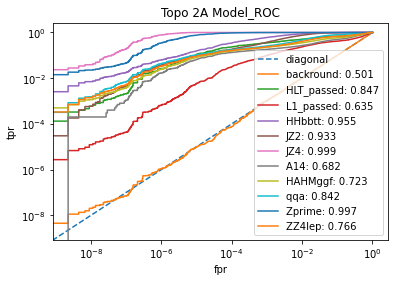

In [15]:
#Topo 2A Analyses

Losses=['CKL']
for string in Losses:
    #evaluation=Model_Evaluator('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/trained_models/L1_models/Topo_2A/Topo_2A_Version_1/',Topo_2A_test_br,Topo_br_weights,[Topo_2A_test_signal,Topo_2A_HLT_passed,Topo_2A_L1_passed,Topo_2A_just_L1_passed,Topo_2A_HHbbtt,Topo_2A_HHbbtt_unpassed,Topo_2A_jz2,Topo_2A_jz4],[Topo_signal_weights,Topo_signal_weights[HLT_pass_test==1],Topo_signal_weights[L1_pass_test==1],Topo_signal_weights[L1_pass_test==1][HLT_pass_test[L1_pass_test==1]==0],np.ones(len(Topo_2A_HHbbtt)),np.ones(len(Topo_2A_HHbbtt_unpassed)),np.ones(len(Topo_2A_jz2)),np.ones(len(Topo_2A_jz4))],input_dim=111,title='Topo 2A Model'.format(string), save=False,labels=['backround','HLT_passed','L1_passed','just_L1_passed','HHbbtt','Undetected HHbbtt','JZ2','JZ4'])
    evaluation=Model_Evaluator('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/trained_models/L1_models/Topo_2A/Topo_2A_Version_1/',Topo_2A_test_br,Topo_br_weights,[Topo_2A_test_signal,Topo_2A_HLT_passed,Topo_2A_L1_passed,Topo_2A_HHbbtt,Topo_2A_jz2,Topo_2A_jz4,Topo_2A_A14,Topo_2A_HAHMggf,Topo_2A_qqa,Topo_2A_Zprime,Topo_2A_ZZ4lep],[Topo_signal_weights,Topo_signal_weights[HLT_pass_test==1],Topo_signal_weights[L1_pass_test==1],np.ones(len(Topo_2A_HHbbtt)),np.ones(len(Topo_2A_jz2)),np.ones(len(Topo_2A_jz4)),np.ones(len(Topo_2A_A14)),np.ones(len(Topo_2A_HAHMggf)),np.ones(len(Topo_2A_qqa)),np.ones(len(Topo_2A_Zprime)),np.ones(len(Topo_2A_ZZ4lep))],input_dim=111,title='Topo 2A Model'.format(string), save=False,labels=['backround','HLT_passed','L1_passed','HHbbtt','JZ2','JZ4','A14','HAHMggf','qqa','Zprime','ZZ4lep'])
    A2_MSE=evaluation.calculate_loss('MSE')[0]
    A2_loss=evaluation.calculate_loss(string)[1][0]
    #A2_triggered=evaluation.event_anomally_checker(10**-5)
    #evaluation.Sensitivity()
    #evaluation.S_F(40*10**6,40*10)
    #evaluation.histogram(bins=100)
    evaluation.ROC()
    #evaluation.Plot_2D()
    #evaluation.pt_correlation()

In [ ]:
#2A_unweighted
Losses=['CKL']
for string in Losses:
    evaluation=Model_Evaluator('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/trained_models/L1_models/Topo_2A/Topo_2A_Version_1/',Topo_2A_test_br,np.ones(len(Topo_2A_test_br)),[Topo_2A_test_signal,Topo_2A_HLT_passed,Topo_2A_L1_passed,Topo_2A_just_L1_passed,Topo_2A_HHbbtt,Topo_2A_jz2,Topo_2A_jz4],[np.ones(len(Topo_2A_test_signal)),np.ones(len(Topo_2A_HLT_passed)),np.ones(len(Topo_2A_L1_passed)),np.ones(len(Topo_2A_just_L1_passed)),np.ones(len(Topo_2A_HHbbtt)),np.ones(len(Topo_2A_jz2)),np.ones(len(Topo_2A_jz4))],input_dim=111,title='Topo 2A Model'.format(string), save=False,labels=['backround','HLT_passed','L1_passed','just_L1_passed','HHbbtt','JZ2','JZ4'])
    #A2_MSE=evaluation.calculate_loss('MSE')[0]
    A2_loss=evaluation.calculate_loss(string)[1][0]
    #A2_triggered=evaluation.event_anomally_checker(10**-5)
    #evaluation.Sensitivity()
    #evaluation.S_F(40*10**6,40*10)
    #evaluation.histogram(bins=100)
    evaluation.ROC()
    #evaluation.Plot_2D()
    #evaluation.pt_correlation()

3125/3125 [==============================] - 5s 1ms/step


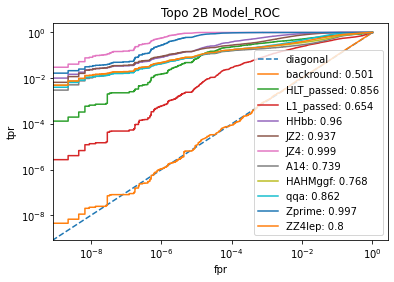

In [16]:
#Topo 2B Analyses

Losses=['CKL']
for string in Losses:
    #evaluation=Model_Evaluator('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/trained_models/L1_models/Topo_2B/Topo_2B_Version_1/',Topo_2B_test_br,Topo_br_weights,[Topo_2B_test_signal,Topo_2B_HLT_passed,Topo_2B_L1_passed,Topo_2B_just_L1_passed,Topo_2B_HHbbtt,Topo_2B_HHbbtt_unpassed,Topo_2B_jz2,Topo_2B_jz4],[Topo_signal_weights,Topo_signal_weights[HLT_pass_test==1],Topo_signal_weights[L1_pass_test==1],Topo_signal_weights[L1_pass_test==1][HLT_pass_test[L1_pass_test==1]==0],np.ones(len(Topo_2B_HHbbtt)),np.ones(len(Topo_2B_HHbbtt_unpassed)),np.ones(len(Topo_2B_jz2)),np.ones(len(Topo_2B_jz4))],input_dim=75,title='Topo 2B Model', save=False,labels=['backround','HLT_passed','L1_passed','just_L1_passed','HHbb','HHbb Undetected','JZ2','JZ4'])
    evaluation=Model_Evaluator('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/trained_models/L1_models/Topo_2B/Topo_2B_Version_1/',Topo_2B_test_br,Topo_br_weights,[Topo_2B_test_signal,Topo_2B_HLT_passed,Topo_2B_L1_passed,Topo_2B_HHbbtt,Topo_2B_jz2,Topo_2B_jz4,Topo_2B_A14,Topo_2B_HAHMggf,Topo_2B_qqa,Topo_2B_Zprime,Topo_2B_ZZ4lep],[Topo_signal_weights,Topo_signal_weights[HLT_pass_test==1],Topo_signal_weights[L1_pass_test==1],np.ones(len(Topo_2B_HHbbtt)),np.ones(len(Topo_2B_jz2)),np.ones(len(Topo_2B_jz4)),np.ones(len(Topo_2B_A14)),np.ones(len(Topo_2B_HAHMggf)),np.ones(len(Topo_2B_qqa)),np.ones(len(Topo_2B_Zprime)),np.ones(len(Topo_2B_ZZ4lep))],input_dim=75,title='Topo 2B Model', save=False,labels=['backround','HLT_passed','L1_passed','HHbb','JZ2','JZ4','A14','HAHMggf','qqa','Zprime','ZZ4lep'])
    B2_MSE=evaluation.calculate_loss('MSE')[0]
    B2_loss=evaluation.calculate_loss(string)[1][0]
    #B2_triggered=evaluation.event_anomally_checker(10**-5)
    #evaluation.Sensitivity()
    #evaluation.S_F(40*10**6,40*10)
    #evaluation.histogram(bins=100)
    evaluation.ROC()
    #evaluation.Plot_2D()
    #evaluation.pt_correlation()

3125/3125 [==============================] - 5s 1ms/step


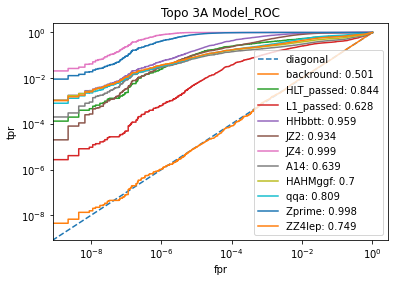

In [19]:
#Topo 3A Analyses

Losses=['CKL']
for string in Losses:
    #evaluation=Model_Evaluator('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/trained_models/L1_models/Topo_3A/Topo_3A_Version_1/',Topo_3A_test_br,Topo_br_weights,[Topo_3A_test_signal,Topo_3A_HLT_passed,Topo_3A_L1_passed,Topo_3A_just_L1_passed,Topo_3A_HHbbtt,Topo_3A_HHbbtt_unpassed,Topo_3A_jz2,Topo_3A_jz4],[Topo_signal_weights,Topo_signal_weights[HLT_pass_test==1],Topo_signal_weights[L1_pass_test==1],Topo_signal_weights[L1_pass_test==1][HLT_pass_test[L1_pass_test==1]==0],np.ones(len(Topo_3A_HHbbtt)),np.ones(len(Topo_3A_HHbbtt_unpassed)),np.ones(len(Topo_3A_jz2)),np.ones(len(Topo_3A_jz4))],input_dim=93,title='Topo 3A Model', save=True,labels=['backround','HLT_passed','L1_passed','just_L1_passed','HHbb','HHbb undetected','JZ2','JZ4'])
    evaluation=Model_Evaluator('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/trained_models/L1_models/Topo_3A/Topo_3A_Version_1/',Topo_3A_test_br,Topo_br_weights,[Topo_3A_test_signal,Topo_3A_HLT_passed,Topo_3A_L1_passed,Topo_3A_HHbbtt,Topo_3A_jz2,Topo_3A_jz4,Topo_3A_A14,Topo_3A_HAHMggf,Topo_3A_qqa,Topo_3A_Zprime,Topo_3A_ZZ4lep],[Topo_signal_weights,Topo_signal_weights[HLT_pass_test==1],Topo_signal_weights[L1_pass_test==1],np.ones(len(Topo_3A_HHbbtt)),np.ones(len(Topo_3A_jz2)),np.ones(len(Topo_3A_jz4)),np.ones(len(Topo_3A_A14)),np.ones(len(Topo_3A_HAHMggf)),np.ones(len(Topo_3A_qqa)),np.ones(len(Topo_3A_Zprime)),np.ones(len(Topo_3A_ZZ4lep))],input_dim=93,title='Topo 3A Model', save=True,labels=['backround','HLT_passed','L1_passed','HHbbtt','JZ2','JZ4','A14','HAHMggf','qqa','Zprime','ZZ4lep'])
    A3_MSE=evaluation.calculate_loss('MSE')[0]
    A3_loss=evaluation.calculate_loss(string)[1][0]
    #A3_triggered=evaluation.event_anomally_checker(10**-5)
    #evaluation.Sensitivity()
    #evaluation.S_F(40*10**6,40*10)
    #evaluation.histogram(bins=100)
    evaluation.ROC()
    #evaluation.Plot_2D()
    #evaluation.pt_correlation()

In [18]:
import scipy
def Gaussian(x,A,sigma,mu,B):
    y=A*np.exp(-0.5*(((x-mu)/sigma))**2)+B
    return y

In [ ]:
x=np.linspace(0,len(A2_loss),len(A2_loss))
A2_loss_ave=np.array(A2_loss)/np.mean(A2_loss)
B2_loss_ave=np.array(B2_loss)/np.mean(B2_loss)
A3_loss_ave=np.array(A3_loss)/np.mean(A3_loss)

plt.hist(A2_loss_ave-B2_loss_ave,bins=100)
plt.yscale('log')
plt.xlabel('difference of scores/mean')
plt.title('A2-B2 CLK')
plt.show()
plt.hist(A2_loss_ave-A3_loss_ave,bins=100)
plt.xlabel('difference of scores/mean')
plt.title('A2-A3 CKL')
plt.yscale('log')
plt.show()
plt.hist(B2_loss_ave-A3_loss_ave,bins=100)
plt.xlabel('difference of scores/mean')
plt.title('B2-A3 CKL')
plt.yscale('log')
plt.show()

x=np.linspace(0,len(A2_MSE),len(A2_MSE))
A2_MSE_ave=np.array(A2_MSE)/np.mean(A2_MSE)
B2_MSE_ave=np.array(B2_MSE)/np.mean(B2_MSE)
A3_MSE_ave=np.array(A3_MSE)/np.mean(A3_MSE)

plt.hist(A2_MSE_ave-B2_MSE_ave,bins=100)
plt.yscale('log')
plt.xlabel('difference of scores/mean')
plt.title('A2-B2 MSE')
plt.show()
plt.hist(A2_MSE_ave-A3_MSE_ave,bins=100)
plt.xlabel('difference of scores/mean')
plt.title('A2-A3 MSE')
plt.yscale('log')
plt.show()
plt.hist(B2_MSE_ave-A3_MSE_ave,bins=100)
plt.xlabel('difference of scores/mean')
plt.title('B2-A3 MSE')
plt.yscale('log')
plt.show()


In [ ]:
def list_or(lists):
    entries=[]
    for list in lists:
        for item in list:
            check=0
            for ent in entries:
                if item==ent:
                    check=1
            if check==0:
                entries+=[item]
    return entries

def list_and(lists):
    e=list_or(lists)
    final=[]
    for ent in e:
        big_check=0
        check_array=[]
        for i in range(0,len(lists)):
            check_array+=[1]
        for j,list in enumerate(lists):
            for item in list:
                if item==ent:
                    check_array[j]=0
        for i in range(0,len(lists)):
            if check_array[i]==1:
                big_check=1
        if big_check==0:
            final+=[ent]
    return final

In [ ]:
A2=A2_triggered
B2=B2_triggered
A3=A3_triggered
labels=['backround','HLT_passed','L1_passed','just_L1_passed']
print('For a backround rejection of 10**-5\n')
for i in range(0,len(A2)):
    a2b2_passed=len(list_and([A2[i],B2[i]]))
    a3b2_passed=len(list_and([A3[i],B2[i]]))
    a2a3_passed=len(list_and([A2[i],A3[i]]))
    tot_passed=len(list_or([A2[i],B2[i],A3[i]]))
    shared_passed=len(list_and([A2[i],B2[i],A3[i]]))
    print('For signal {}:\n{} events passed A2\n{} events passed B2\n{} events passed A3\n{} events passed A2 and B2\n{} events passed A2 and A3\n{} events passed A3 and B2\n{} events passed 1 or more models\n{} events passed all models\n'.format(labels[i],len(A2[i]),len(B2[i]),len(A3[i]),a2b2_passed,a3b2_passed,a2a3_passed,tot_passed,shared_passed))
    

In [14]:
#Repeat Study Analyses
sensi_non_averaged=[]
for i in range(0,100):
    str='2A_{}'.format(i)
    evaluation=Model_Evaluator('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/trained_models/L1_models/Repeat_Testing/2A_{}/'.format(i),Topo_2A_test_br,Topo_br_weights,[Topo_2A_HHbbtt],[np.ones(len(Topo_2A_HHbbtt))],input_dim=111,title='Topo 2A Model', save=False,labels=['HHbbtt'])
    evaluation.calculate_loss('CKL')
    a=evaluation.weighted_S_F(10**-5)
    print(evaluation.weighted_S_F(10**-5))
    sensi_non_averaged+=[a[0]]

3125/3125 [==============================] - 5s 2ms/step
[0.04828]
3125/3125 [==============================] - 5s 2ms/step
[0.12487]
3125/3125 [==============================] - 5s 2ms/step
[0.18925]
3125/3125 [==============================] - 5s 2ms/step
[0.0681]
3125/3125 [==============================] - 5s 1ms/step
[0.08786]
3125/3125 [==============================] - 5s 2ms/step
[0.05962]
3125/3125 [==============================] - 5s 2ms/step
[0.13379]
3125/3125 [==============================] - 5s 2ms/step
[0.03972]
3125/3125 [==============================] - 5s 2ms/step
[0.08456]
3125/3125 [==============================] - 5s 2ms/step
[0.09039]
3125/3125 [==============================] - 5s 2ms/step
[0.04375]
3125/3125 [==============================] - 5s 2ms/step
[0.12866]
3125/3125 [==============================] - 5s 1ms/step
[0.06506]
3125/3125 [==============================] - 5s 2ms/step
[0.11843]
3125/3125 [==============================] - 5s 1ms/step
[0.137

In [ ]:
br=Topo_2A_test_br
sig=Topo_2A_HHbbtt
sig_eff=[]
normal_average_eff=[]
def CKL(z_mean):
    CKL=(z_mean[0]**2+z_mean[1]**2+z_mean[2]**2)/3
    return CKL
from sklearn.preprocessing import quantile_transform
for i in range(0,100,10):
    predicts_br=[]
    predicts_sig=[]
    for j in range(0,10):
        evaluation=Model_Evaluator('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/trained_models/L1_models/Repeat_Testing/2A_{}/'.format(i+j),Topo_2A_test_br,Topo_br_weights,[Topo_2A_HHbbtt],[np.ones(len(Topo_2A_HHbbtt))],input_dim=111,title='Topo 2A Model', save=False,labels=['HHbbtt'])
        br_pred=evaluation.encoder.predict(br)[0]
        br_s=[]
        sig_pred=evaluation.encoder.predict(sig)[0]
        sig_s=[]
        for k in br_pred:
            br_s+=[CKL(k)]
        for l in sig_pred:
            sig_s+=[CKL(l)]
        print(np.array(br_s).shape)
        predicts_br+=[br_s]
        predicts_sig+=[sig_s]
            

    sf_list=[]
    for g, batch in enumerate(predicts_sig):
      sig_w=np.ones(len(Topo_2A_HHbbtt))
      br_w=Topo_br_weights
      weights=np.concatenate((br_w,sig_w))
      print(len(weights))
      truth=[]
      for m in range(len(predicts_br[g])):
        truth+=[0]
      for n in range(len(batch)):
        truth+=[1]
      print(len(truth))
      ROC_data=np.concatenate((predicts_br[g],batch))
      print(len(ROC_data))
      fpr,tpr,x=sk.roc_curve(truth,ROC_data,sample_weight=weights)
    #auc=np.trapz(tpr,fpr)
      saved=0
      saved_index=0
      for k,f in enumerate(fpr):
          if f>rate:
              pass
          elif f>=saved:
              saved=f
              saved_index=k
      sf_list+=[tpr[k]]
    sig_eff+=[sf_list[0]]
    
    
    
    


In [15]:
sensi_non_averaged2=[]
for i in range(0,100):
    str='2A_{}'.format(i)
    evaluation=Model_Evaluator('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/trained_models/L1_models/Repeat_Testing/2A_long_{}/'.format(i),Topo_2A_test_br,Topo_br_weights,[Topo_2A_HHbbtt],[np.ones(len(Topo_2A_HHbbtt))],input_dim=111,title='Topo 2A Model', save=False,labels=['HHbbtt'])
    evaluation.calculate_loss('CKL')
    a=evaluation.weighted_S_F(10**-5)
    print(evaluation.weighted_S_F(10**-5))
    sensi_non_averaged2+=[a[0]]

3125/3125 [==============================] - 5s 1ms/step
[0.05317]
3125/3125 [==============================] - 5s 1ms/step
[0.09885]
3125/3125 [==============================] - 5s 2ms/step
[0.16262]
3125/3125 [==============================] - 5s 2ms/step
[0.06717]
3125/3125 [==============================] - 5s 1ms/step
[0.06309]
3125/3125 [==============================] - 5s 1ms/step
[0.07324]
3125/3125 [==============================] - 5s 1ms/step
[0.08106]
3125/3125 [==============================] - 5s 1ms/step
[0.07454]
3125/3125 [==============================] - 5s 1ms/step
[0.06343]
3125/3125 [==============================] - 5s 2ms/step
[0.12941]
3125/3125 [==============================] - 5s 1ms/step
[0.06293]
3125/3125 [==============================] - 5s 1ms/step
[0.04793]
3125/3125 [==============================] - 5s 1ms/step
[0.04743]
3125/3125 [==============================] - 5s 2ms/step
[0.04827]
3125/3125 [==============================] - 5s 2ms/step
[0.09

In [16]:
sensi_non_averaged3=[]
for i in range(0,100):
    str='2A_{}'.format(i)
    evaluation=Model_Evaluator('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/trained_models/L1_models/Repeat_Testing/2A_fixed_{}/'.format(i),Topo_2A_test_br,Topo_br_weights,[Topo_2A_HHbbtt],[np.ones(len(Topo_2A_HHbbtt))],input_dim=111,title='Topo 2A Model', save=False,labels=['HHbbtt'])
    evaluation.calculate_loss('CKL')
    a=evaluation.weighted_S_F(10**-5)
    print(evaluation.weighted_S_F(10**-5))
    sensi_non_averaged3+=[a[0]]

3125/3125 [==============================] - 4s 1ms/step
[0.19245]
3125/3125 [==============================] - 5s 2ms/step
[0.11344]
3125/3125 [==============================] - 5s 1ms/step
[0.27763]
3125/3125 [==============================] - 4s 1ms/step
[0.12472]
3125/3125 [==============================] - 5s 1ms/step
[0.17354]
3125/3125 [==============================] - 5s 2ms/step
[0.07612]
3125/3125 [==============================] - 5s 1ms/step
[0.0791]
3125/3125 [==============================] - 5s 1ms/step
[0.09437]
3125/3125 [==============================] - 5s 2ms/step
[0.07881]
3125/3125 [==============================] - 4s 1ms/step
[0.12078]
3125/3125 [==============================] - 4s 1ms/step
[0.1794]
3125/3125 [==============================] - 5s 2ms/step
[0.16421]
3125/3125 [==============================] - 5s 1ms/step
[0.06435]
3125/3125 [==============================] - 6s 2ms/step
[0.07336]
3125/3125 [==============================] - 5s 2ms/step
[0.0821

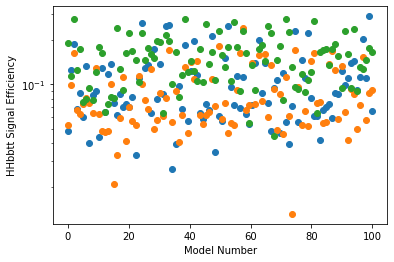

In [17]:
plt.plot(np.linspace(0,100,100),sensi_non_averaged,'o')
#plt.plot(np.linspace(0,100,10),sig_eff,'o')
plt.plot(np.linspace(0,100,100),sensi_non_averaged2,'o')
plt.plot(np.linspace(0,100,100),sensi_non_averaged3,'o')
plt.semilogy()
plt.xlabel('Model Number')
plt.ylabel('HHbbtt Signal Efficiency')
plt.show()

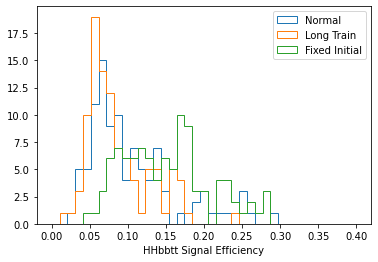

In [19]:
plt.hist(sensi_non_averaged,bins=np.linspace(0,0.4,40),histtype='step',label='Normal')
plt.hist(sensi_non_averaged2,bins=np.linspace(0,0.4,40),histtype='step',label='Long Train')
plt.hist(sensi_non_averaged3,bins=np.linspace(0,0.4,40),histtype='step',label='Fixed Initial')
plt.xlabel('HHbbtt Signal Efficiency')
plt.legend()
plt.show()